# gempy test 


## Convert stratigraphy GML to time-sorted groups and units

<font face color='red'><b>RUN the "map2model_after_topology" notebook first!!<b></font>

Takes GML file produced by topology code, geology polygons, structure points and dtm to create 3D model.<br><br>
Limitations: no faults yet, no plutons yet, no dykes, no sills. Faults and plutons will come soon, sills require us to assign a unique surface to each instance of a sill (sill between units A and B needs to be different from sill of same age and strat codes as one found between E and F). Dykes via cokriging are really hard without just cookie cutting them in (but that is not our problem!). We are not checking for onlap relationships, which can perhaps been seen by having lots of units from one series adjacent to the youngest surface of the older series. Could also think about interpreting these as faults to introduce conceptual uncertainty.

<font face color='red'>The way I loaded data to gempy is not right, so all the units end up in one series... but it gives the basic idea </font>


In [1]:
import matplotlib
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import numpy as np
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import os
import rasterio
from rasterio.transform import from_origin
from rasterio import features
%matplotlib inline
import sys, os
print(os.getcwd())

os.chdir('../map2loop')
import m2l_utils
print(os.getcwd())
os.chdir('../')


C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\notebooks
C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


## Now we define the basic model and load the orientation and lithological information
mj: We inset the model dimensions as once reprojects the edge pixels of the topography are undefined. Probably doesn't need to be that extreme (unit is metres). Could use parameter <b>maxtopo</b> to 

In [2]:
import gempy as gp
import numpy as np
import matplotlib.pyplot as plt
import os
geo_model = gp.create_model('gp_test')

gp.init_data(geo_model, extent=[502536, 600652, 7.458e6, 7.56e6, -3000, 1200],
    resolution = (50,50,50), 
      #path_o = './test_data/output/hams2_orientations.txt',
      path_o = './test_data/output/both_orientations.txt',
      path_i = './test_data/output/hams2_contacts4.txt', default_values=True); #%%

Active grids: ['regular']


## Show example lithological points

In [3]:
gp.get_data(geo_model, 'surface_points').head()

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,561294.769513,7.455348e+06,640,0.543706,0.250100,0.499903,A-FOp-bs,Default series,1,1,1.000000e-08
1,550300.471121,7.458638e+06,476,0.494546,0.264813,0.499170,A-FOp-bs,Default series,1,1,1.000000e-08
2,548389.838343,7.459381e+06,454,0.486003,0.268133,0.499072,A-FOp-bs,Default series,1,1,1.000000e-08
3,541428.338990,7.459826e+06,447,0.454876,0.270123,0.499040,A-FOp-bs,Default series,1,1,1.000000e-08
18,603028.000000,7.481171e+06,658,0.730312,0.365565,0.499984,A-FOp-bs,Default series,1,1,1.000000e-08


## Show example orientations

In [4]:
gp.get_data(geo_model, 'orientations').head()

,X,Y,Z,X_r,Y_r,Z_r,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series,smooth
0,551761.821454,7.486356e+06,548,0.501081,0.388750,0.499492,0.157920,0.701791,0.694658,46.0,12.681676,1.0,A-FOp-bs,Default series,1,1,0.01
1,551761.821454,7.486356e+06,548,0.501081,0.388750,0.499492,0.223952,0.683590,0.694658,46.0,18.139430,1.0,A-FOp-bs,Default series,1,1,0.01
2,554369.942448,7.485184e+06,540,0.512743,0.383507,0.499456,0.169766,0.619964,0.766044,40.0,15.314018,1.0,A-FOp-bs,Default series,1,1,0.01
3,554369.942448,7.485184e+06,540,0.512743,0.383507,0.499456,0.246829,0.593508,0.766044,40.0,22.581489,1.0,A-FOp-bs,Default series,1,1,0.01
4,546514.161348,7.488545e+06,679,0.477616,0.398538,0.500078,0.189869,0.742141,0.642788,50.0,14.350716,1.0,A-FOp-bs,Default series,1,1,0.01


## Plot some of this data

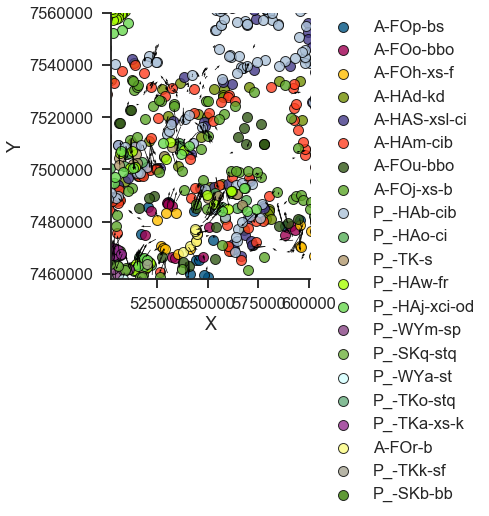

In [5]:
%matplotlib inline
gp.plot.plot_data(geo_model, direction='z');

## Load reprojected topgraphy to model

In [7]:
fp = './test_data/dtm/hams2_dtm_rp.tif'
geo_model.set_topography(source='gdal',filepath=fp)

## Load stratigraphic Series

f=open('./test_data/tmp/hams2_groups.txt',"r")
contents =f.readlines()
f.close


faults = gp.Faults()
series = gp.Series(faults)
series.df

ngroups=int(contents[0][0])
groups=[]

for i in range (1,int(ngroups)+1):
    groups.append(contents[i].replace("\n",""))
    series.add_series(contents[i].replace("\n",""))

series.delete_series('Default series')

series

Filepath seems to be wrong.


AttributeError: 'NoneType' object has no attribute 'ReadAsArray'

## Load surfaces and assign to series

In [ ]:
surfaces = gp.Surfaces(series)


for i in range(0,ngroups):
    f=open('./test_data/tmp/'+groups[i]+'.txt',"r")
    contents =f.readlines()
    nformations=str(contents[0])
    nformations=nformations.split(" ")
    nformations=int(nformations[1].replace("\n",""))

    for j in range (1,int(nformations)+1):
        surfaces.add_surface(contents[j].replace("\n",""))
        d={groups[i]:contents[j].replace("\n","")}
        surfaces.map_series({groups[i]:(contents[j].replace("\n",""))}) #working but no gps
        #gp.map_series_to_surfaces(geo_model, {groups[0]:(contents[j].replace("\n",""))},#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX<<<<
              #  set_series=True, remove_unused_series=True)
    f.close

surfaces

## Set Interpolation Data

In [ ]:

id_only_one_bool = geo_model.surface_points.df['id'].value_counts() == 1
id_only_one = id_only_one_bool.index[id_only_one_bool]
single_vals = geo_model.surface_points.df[geo_model.surface_points.df['id'].isin(id_only_one)]
for idx, vals in single_vals.iterrows():
    geo_model.add_surface_points(vals['X'], vals['Y'], vals['Z'], vals['surface'])
    
geo_model.update_structure()


In [ ]:
gp.set_interpolation_data(geo_model,
                          compile_theano=True,
                          theano_optimizer='fast_compile',
                          verbose=[])

## Provide summary data on model

In [ ]:
geo_model.additional_data.structure_data

## Calculate Model

In [ ]:


gp.compute_model(geo_model)

## Extract surfaces to visualize in 3D renderers

In [ ]:
gp.plot.plot_section(geo_model, 49, direction='z', show_data=False)

In [ ]:
ver , sim = gp.get_surfaces(geo_model)

## Visualise model

In [ ]:
gp.plot.plot_3D(geo_model)

## Export model to vtk files

from gempy import plot
gp.plot.export_to_vtk(geo_model, path='.\\vtk\\', name=mname+'.vtk', voxels=False, block=None, surfaces=True)